In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA2'

In [2]:
!du -sh /home/roman/mne_data

60G	/home/roman/mne_data


In [3]:
import sys, os, torch
from tqdm import tqdm
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [9]:
%%time

ds = Weibo2014()
cprint(ds.interval, 'grey', 'on_yellow')

print(f'N_subj: {len(ds.subject_list)}')


ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
eventsOI = ['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']

subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=0,
                            tmax=None, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)



[3, 7]
N_subj: 10


  0%|                                                                                                                                  | 0/10 [00:00<?, ?it/s]

['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 10%|████████████▏                                                                                                             | 1/10 [00:10<01:32, 10.27s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 20%|████████████████████████▍                                                                                                 | 2/10 [00:20<01:22, 10.31s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 30%|████████████████████████████████████▌                                                                                     | 3/10 [00:31<01:12, 10.36s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 40%|████████████████████████████████████████████████▊                                                                         | 4/10 [00:41<01:02, 10.34s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 50%|█████████████████████████████████████████████████████████████                                                             | 5/10 [00:51<00:51, 10.32s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 60%|█████████████████████████████████████████████████████████████████████████▏                                                | 6/10 [01:00<00:39,  9.95s/it]

(500, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 70%|█████████████████████████████████████████████████████████████████████████████████████▍                                    | 7/10 [01:11<00:30, 10.10s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8/10 [01:21<00:20, 10.17s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9/10 [01:31<00:10, 10.24s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
['left_hand', 'right_hand', 'hands', 'feet', 'left_hand_right_foot', 'right_hand_left_foot', 'rest']


Trial data de-meaned and concatenated with a buffer to create cont data
Trial data de-meaned and concatenated with a buffer to create cont data
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:42<00:00, 10.22s/it]

(560, 7, 240), ['feet' 'hands' 'left_hand' 'left_hand_right_foot' 'rest' 'right_hand'
 'right_hand_left_foot']
CPU times: user 1min 31s, sys: 10.9 s, total: 1min 42s
Wall time: 1min 42s


{'left_hand': 1,
 'right_hand': 2,
 'hands': 3,
 'feet': 4,
 'left_hand_right_foot': 5,
 'right_hand_left_foot': 6,
 'rest': 7}

In [11]:
labelsToIDs = ds.event_id
pprint(labelsToIDs)

def save_to_torch(samples, meta, ds):    
    torch.save({'samples': torch.from_numpy(samples).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ChOI,
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

{'feet': 4,
 'hands': 3,
 'left_hand': 1,
 'left_hand_right_foot': 5,
 'rest': 7,
 'right_hand': 2,
 'right_hand_left_foot': 6}


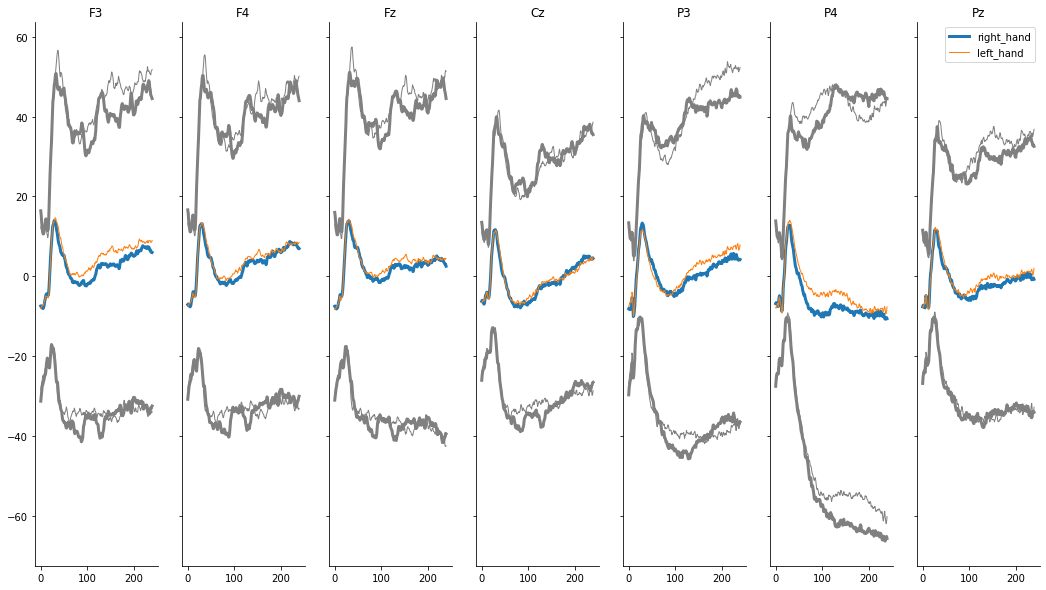

In [15]:
rights = np.where(meta.label.map(labelsToIDs) == 2)[0]
lefts = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1,7, figsize=(18,10), sharey=True)
for i in range(7):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[lefts,i,:].mean(0).squeeze()
    s = samples[lefts,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='left_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()